<h1><p style="text-align:center">Vehicle Fuel Efficiency Analysis and Modelling</p></h1>

## Business Context

Fuel Economy is a key driver of total cost of ownership, pricing competitiveness, and regulatory compliance in the automotive industry.

Consumer Reports Magazine, a trusted source for information on consumer products and services seeks to understand which vehicle characteristics influence fuel efficiency.

## Business Problem

Fuel economy is a critical driver of vehicle ownership cost and a key consideration for consumers. To support an upcoming article and inform strategic decision-making, the organization seeks to analyze how automobile characteristics influence fuel efficiency.

Specifically, the organization aims to:

* Identify the vehicle attributes that has the greatest impact on fuel economy
* Develop a predict model to estimate fuel economy based on vehicle characterisitics
* Translate analytical and modelling results into actionable insights to inform product positioning, pricing strategies, and consumer guidance.

## Analytical Objective

Prepare and explore data, build and evaluate a multiple linear regression model to predict vehicle fuel efficiency(MPG), and interpret model outputs.

## Data Overview

Field  |  Description
------- | -----------
mpg  | The fuel economy of the car in terms of miles travelled per gallon of gasoline
cylinders | The number of cylinders in the car's engine
displacement | The volume of air displaced by all the pistons of a piston engine
horsepower | Horsepower is a measure of power the engine produces
weight | The total weight of the car
acceleration | The time in seconds it takes for the car to reach 60 miles per hour
model year | The year (in the 20th century) the car model was released
origin | The region where the car was manufactured. 1 - USA. 2 - Europe. 3 - Japan
car name | The name of the car model.

In [1]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2

In [2]:
# set plotting theme
sns.set_theme(style="darkgrid", )

In [3]:
# load data
file = "auto-mpg.csv"
auto_df = pd.read_csv(file)

# display few rows of data
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
auto_df.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


In [5]:
# Dataframe info
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
# Check for duplicated rows
auto_df.duplicated().sum()

np.int64(0)

In [7]:
# Descriptive statistics of the dataframe
auto_df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [8]:
auto_df.describe(include="object")

,horsepower,car name
count,398,398
unique,94,305
top,150,ford pinto
freq,22,6


From the initial inspection, no much cleaning to be done in this data, except the `origin` and `horsepower` columns that has wrong datatype.
For the `model year` column, since the years are in 20th Century, I will prefix `19` to each value for proper year identification.

# Data Cleaning

In [9]:
# rename columns
auto_df.rename(columns={"model year":"model_year", "car name":"car_name"}, inplace=True)

In [10]:
auto_df.origin.unique()

array([1, 3, 2])

In [11]:
# map string to values in origin column

origin_map = {
    1:"USA",
    2:"Europe",
    3:"Japan"
}

auto_df = auto_df.assign(
    origin = auto_df.origin.map(origin_map),
    horsepower = pd.to_numeric(auto_df.horsepower.replace("?", np.nan))
)

<Axes: >

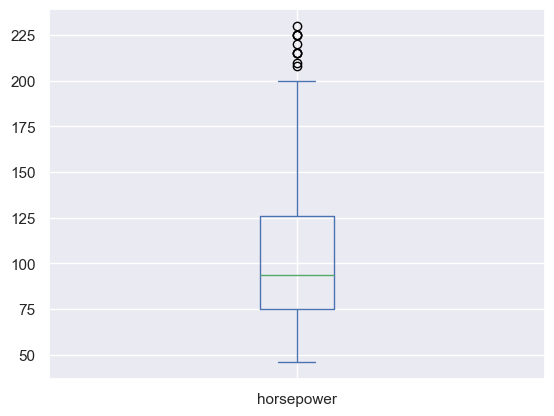

In [12]:
auto_df.horsepower.plot.box()

In [13]:
# Rpelacing missing values in horsepower with the median
auto_df["horsepower"] = auto_df["horsepower"].fillna(np.median(auto_df.horsepower))

In [14]:
auto_df.origin.unique()

array(['USA', 'Japan', 'Europe'], dtype=object)

In [15]:
# Prefix 19 to model_year values
auto_df["model_year"] = ("19" + auto_df["model_year"].astype(str)).astype(int)

In [16]:
auto_df.model_year.unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982])

# Exploratory Data Analysis

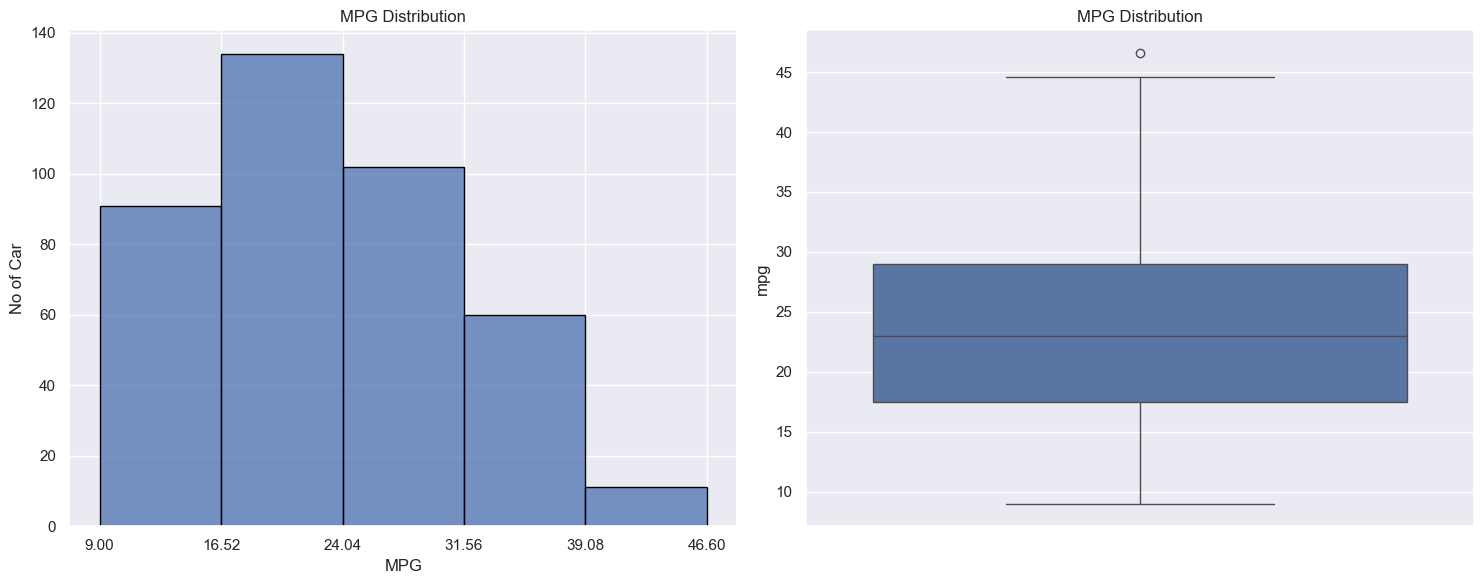

In [17]:
# Target Exploration
count, no_bins = np.histogram(auto_df["mpg"], bins=5)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(auto_df.mpg, bins=no_bins, edgecolor="black", ax=axes[0])
sns.boxplot(auto_df.mpg, ax=axes[1])

axes[0].set_title("MPG Distribution")
axes[0].set_xlabel("MPG")
axes[0].set_ylabel("No of Car")
axes[0].set_xticks(no_bins)

axes[1].set_title("MPG Distribution")

plt.tight_layout()
plt.show()

## Features Exploration

In [18]:
def explore_numeric(dataframe, features):
    n_cols = 2
    n_rows = len(features)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

    for i, col in enumerate(features):
        # First plot in rows
        sns.histplot(data=dataframe, x=col, edgecolor="black", ax=axes[i, 0])

        axes[i, 0].set_title(f"{col} Distribution")
        axes[i, 0].set_ylabel("No of Car")
        axes[i, 0].set_xlabel(col)
        #axes[i, 0].set_xticks(bins)

        # Second plot in row
        sns.boxplot(data=dataframe, x=col, ax=axes[i, 1])

        axes[i, 1].set_title(f"{col} Boxplot")

    plt.tight_layout()
    plt.show()

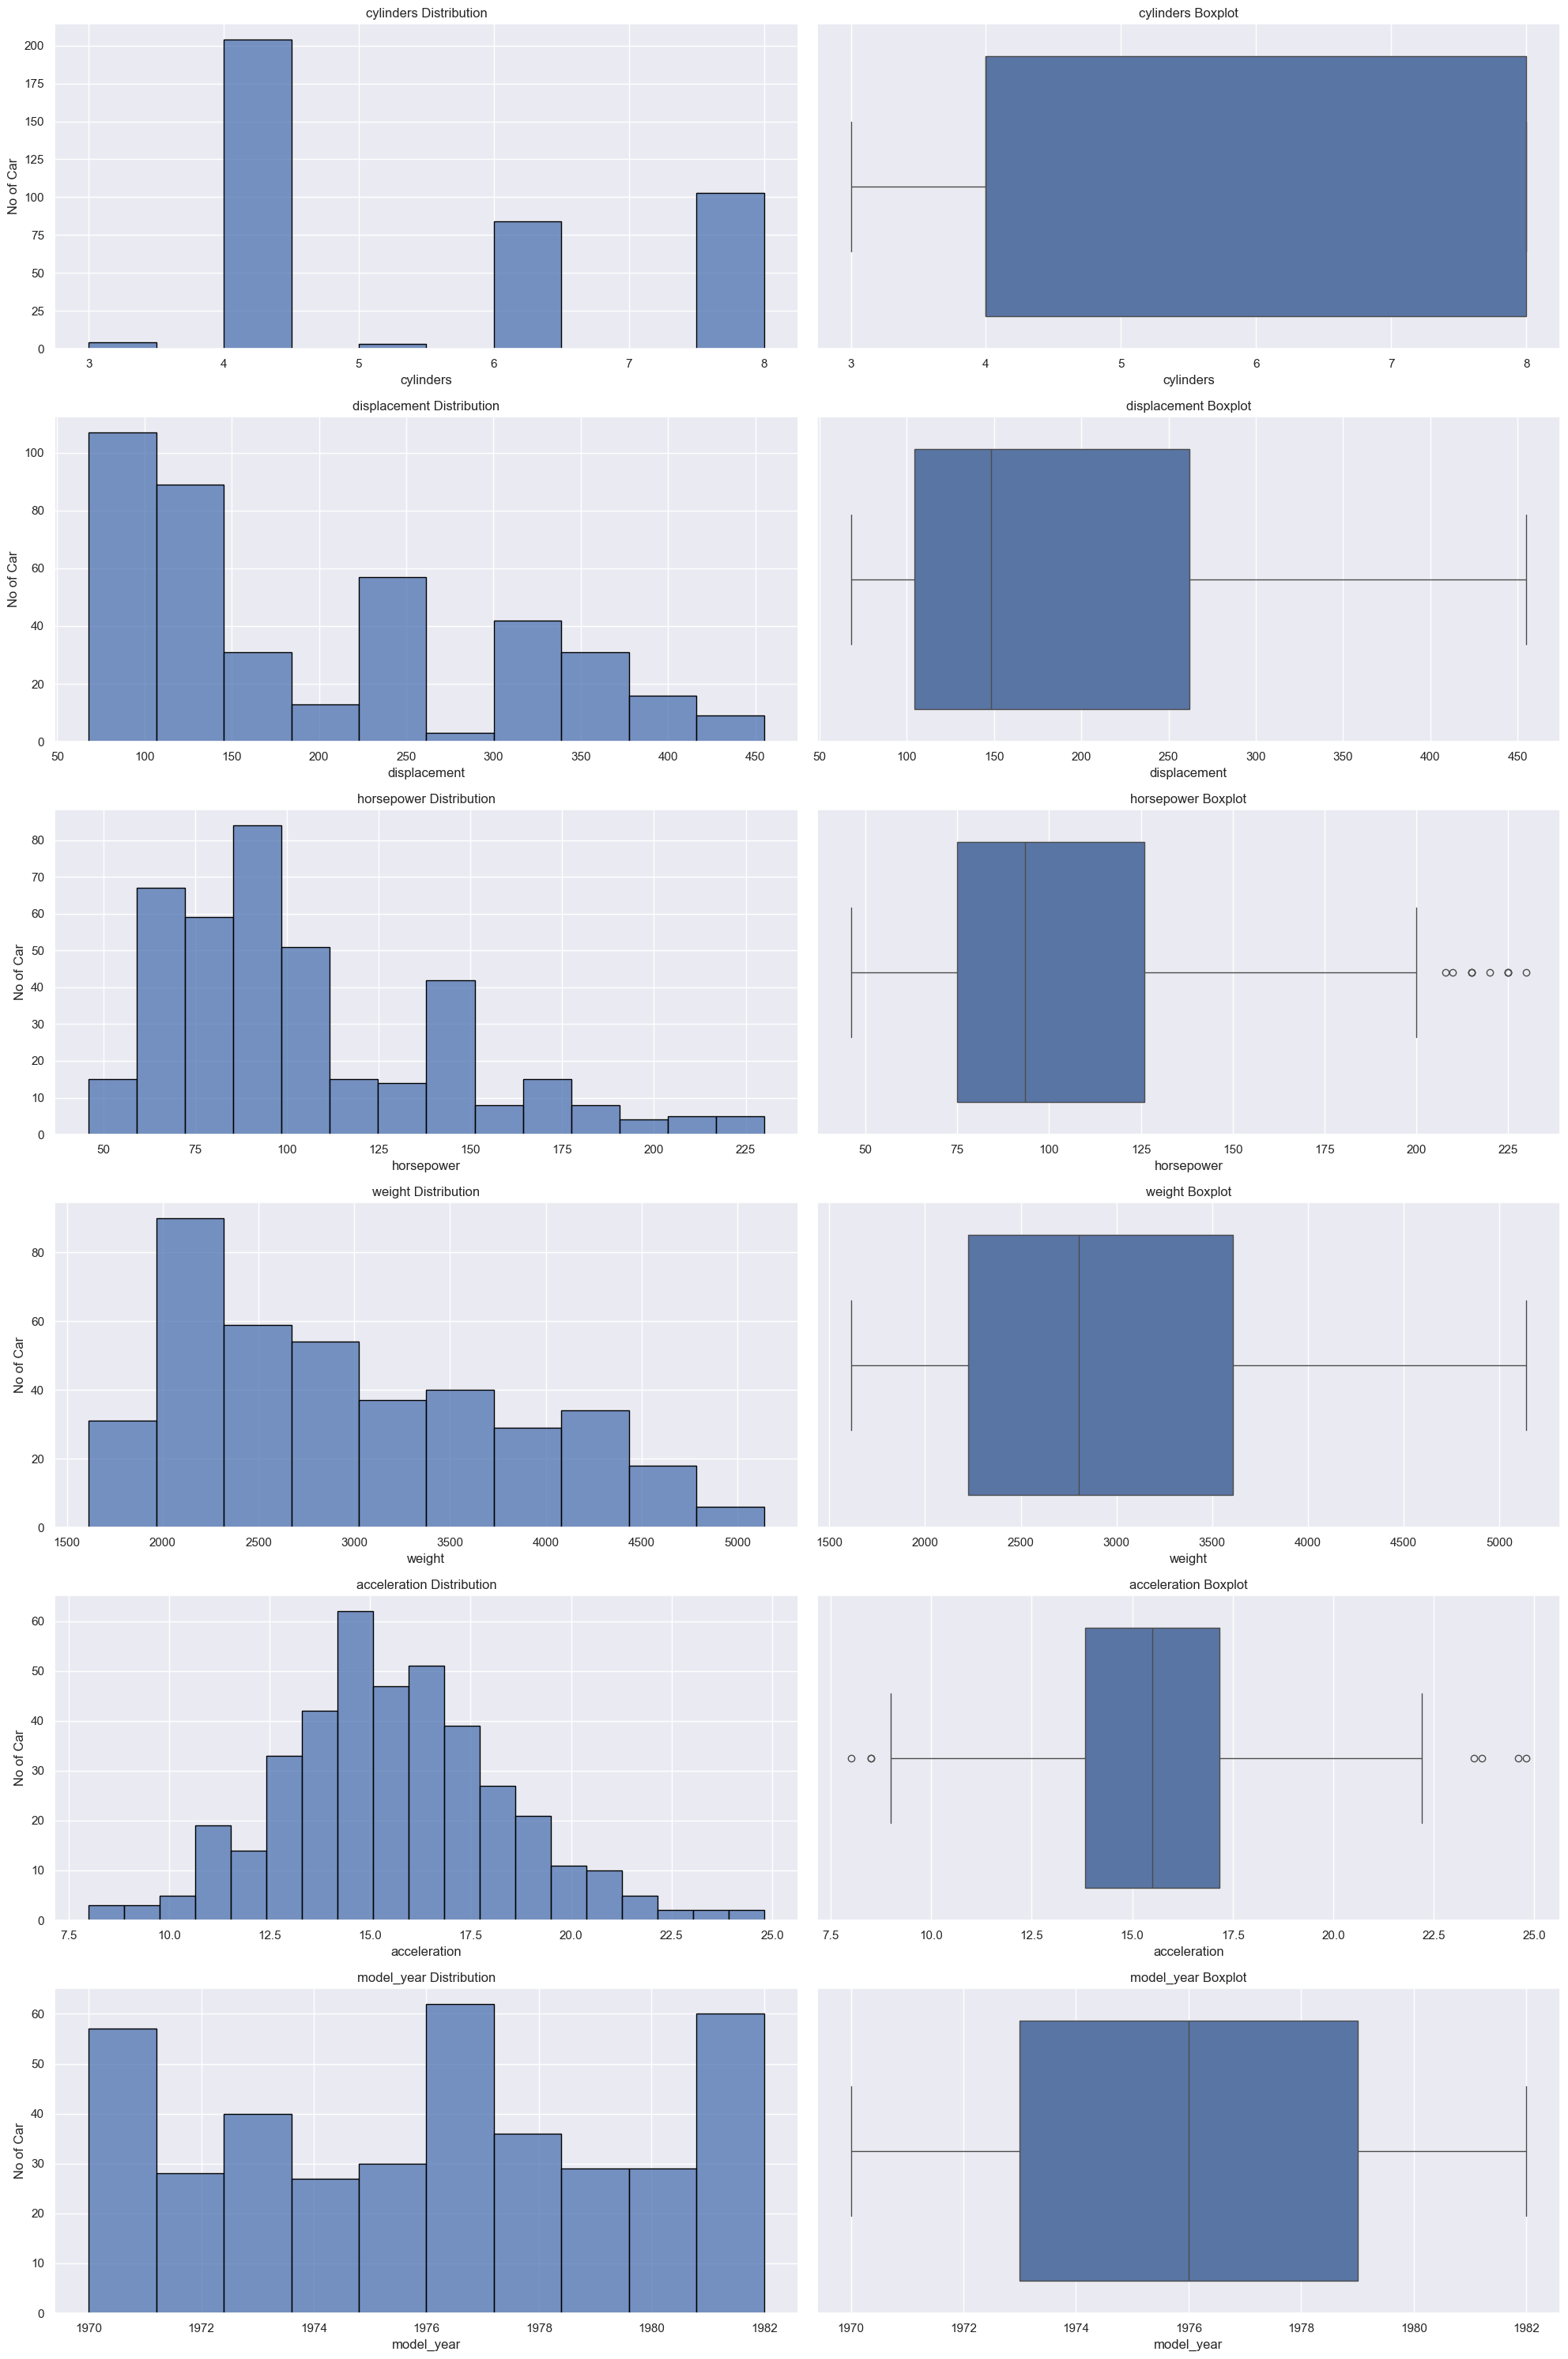

In [19]:
explore_numeric(dataframe=auto_df, features=["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"])

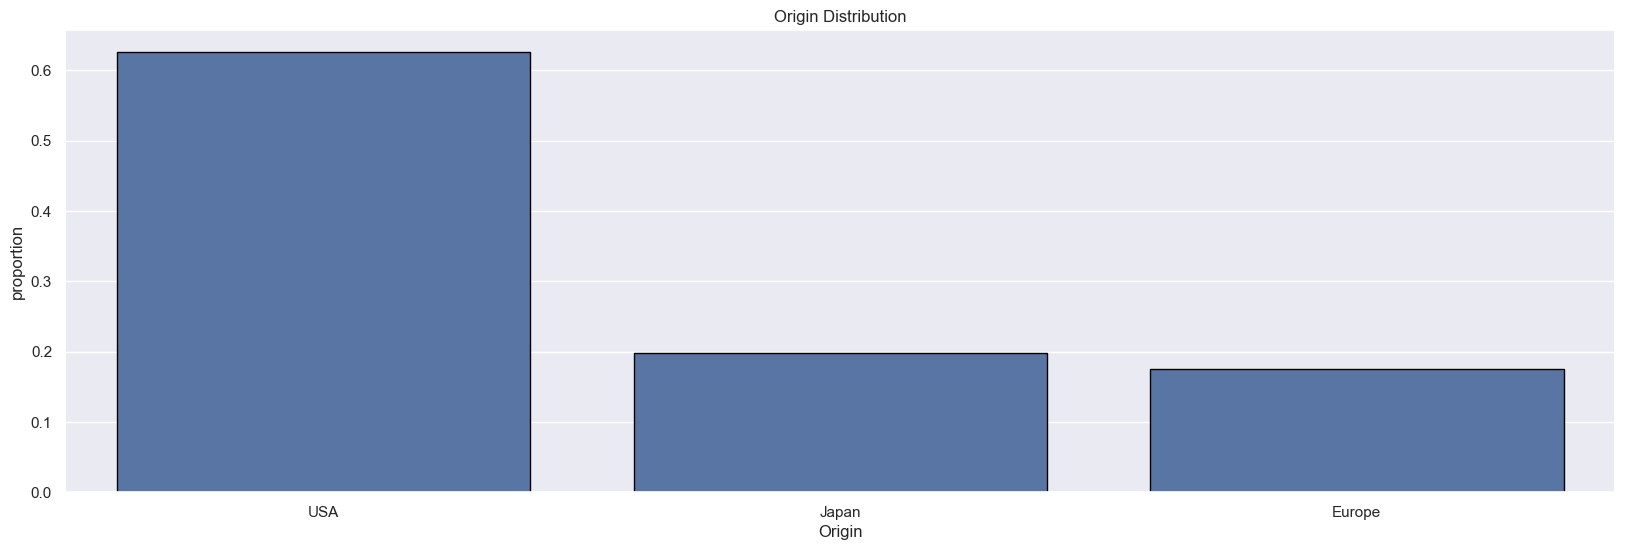

In [20]:
origin_count = auto_df.origin.value_counts(normalize=True)

plt.figure(figsize=(20,6))
sns.barplot(origin_count, edgecolor="black")

plt.title("Origin Distribution")
plt.xlabel("Origin");

1. **MPG**: Approximately 82% of the cars have fuel efficiency values between 32 and 90 mpg, with an average mpg of 23.
2. **Cylinders**: Out of 398, 200 have 4 cylinders while 3 and 5 cylinders are the least common.
3. **Displacement**: Around 190 cars have engine displacement within the range of 60 - 150
4. **Horsepower**: Majority of the cars have less than 100 horsepower.
5. **Origin**: Over 60% of cars were manufacuterd in USA.